In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import mudata as md
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from utils.utils import calc_sparsity
from sklearn.covariance import empirical_covariance
from scipy.stats import pearsonr
from tqdm import tqdm

In [2]:
ec_mudata = md.read("../data/preprocessed/efm_mudata_prepro.h5mu")
ec_mudata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 2434 × 4096
  3 modalities
    all_genes:	2434 x 2048
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'neighbors', 'protein_match', 'umap', 'unmatch_genes'
      obsm:	'X_pca', 'X_umap'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
      obsp:	'connectivities', 'distances'
    high_abundance_genes:	2434 x 800
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'neighbors', 'protein_match', 'umap', 'unmatch_genes'
      obsm:	'X_pca', 'X_umap'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
      obsp:	'connectivities', 'distances'
    low_abundance_genes:	2434 x 1248
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'neighbors', 'protein_match', 'umap', 'unmatch_genes'
      obsm:	'X_pca', 'X_umap'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
      obsp:	'connectivities', 'distances'

### Mean and Median of cell counts

In [3]:
print(np.mean(np.sum(ec_mudata["high_abundance_genes"].X.A, axis=1)))
print(np.median(np.sum(ec_mudata["high_abundance_genes"].X.A, axis=1)))

24.029171
19.0


### Mean and Median of gene counts

In [4]:
print(np.mean(np.sum(ec_mudata["high_abundance_genes"].X.A, axis=0)))
print(np.median(np.sum(ec_mudata["high_abundance_genes"].X.A, axis=0)))

73.10875
26.0


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


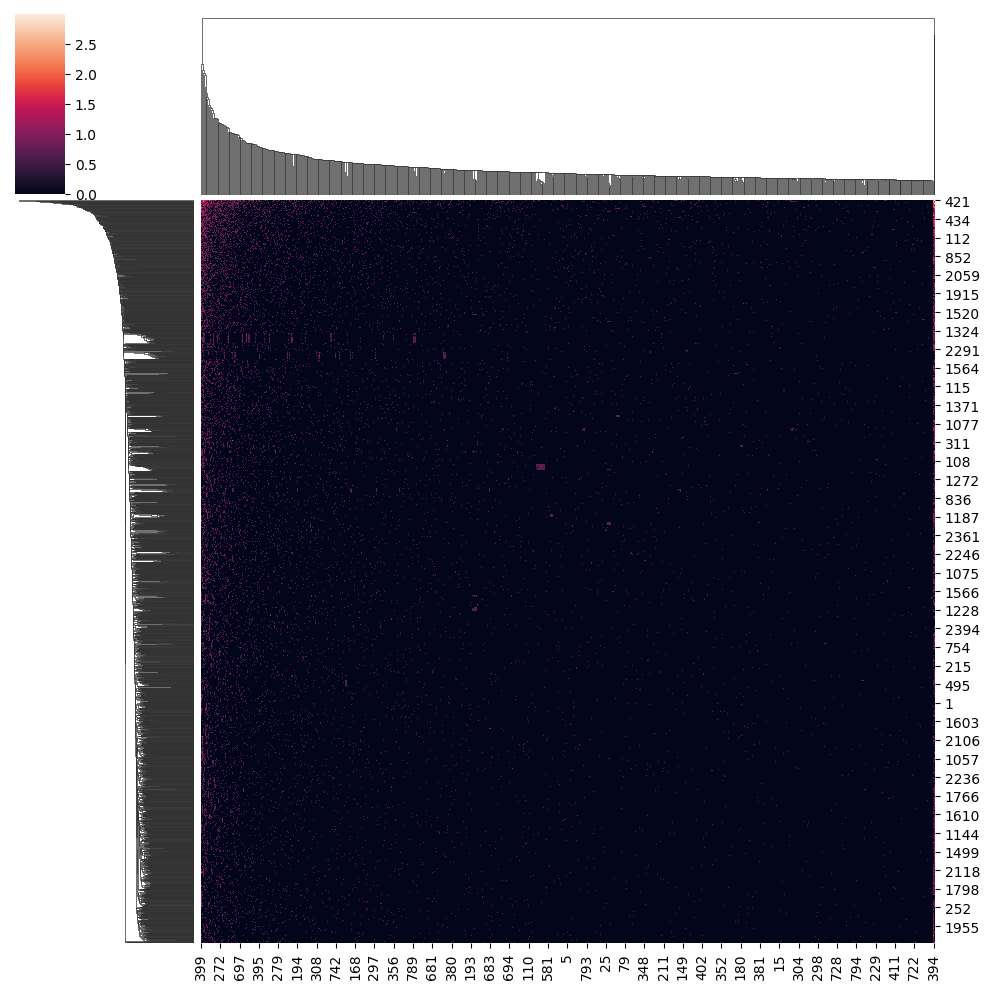

In [5]:
sns.clustermap(np.log1p(ec_mudata["high_abundance_genes"].X.A))

In [6]:
sc.pp.highly_variable_genes(ec_mudata["high_abundance_genes"], layer='raw_counts', n_top_genes=ec_mudata["high_abundance_genes"].shape[1], flavor='seurat_v3')

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='highly_variable_rank', ylabel='total_counts'>

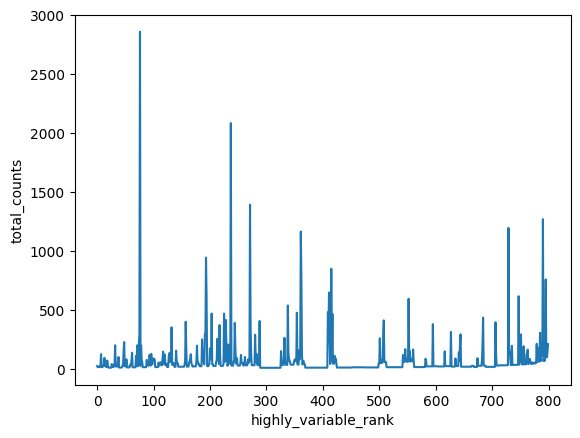

In [7]:
sns.lineplot(data=ec_mudata["high_abundance_genes"].var, x="highly_variable_rank", y="total_counts", color="C0")

### 200 HVG
Selecting the 200 (most) Highly Variables Genes for analysis

In [8]:
hag10_hcc15_hvg200 = ec_mudata["high_abundance_genes"][:, ec_mudata["high_abundance_genes"].var["highly_variable_rank"] <= 200].copy()
hag10_hcc15_hvg200

AnnData object with n_obs × n_vars = 2434 × 201
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'genes_match', 'neighbors', 'protein_match', 'umap', 'unmatch_genes', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    obsp: 'connectivities', 'distances'

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

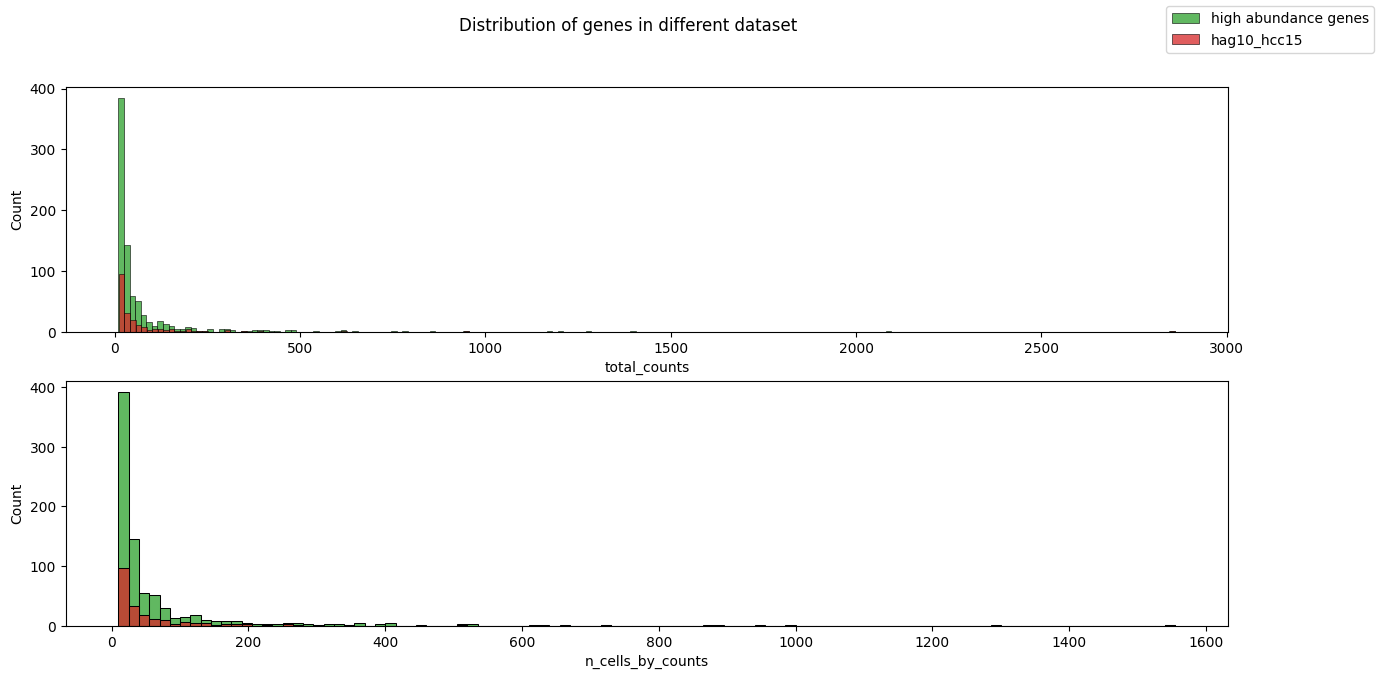

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))
sns.histplot(ec_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])
sns.histplot(hag10_hcc15_hvg200.var["total_counts"], binwidth=15, kde=False, color="C3", label="hag10_hcc15", ax=axes[0])

sns.histplot(ec_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])
sns.histplot(hag10_hcc15_hvg200.var["n_cells_by_counts"], binwidth=15, kde=False, color="C3", ax=axes[1])

#axes[0].set_title("Total counts for genes")
#axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of counts in each cell')

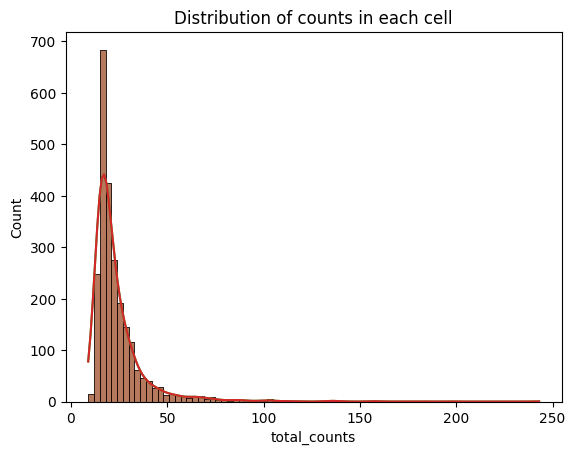

In [10]:
#fig, axes = plt.subplots(1, 1, figsize=(15,7))

sns.histplot(ec_mudata["high_abundance_genes"].obs["total_counts"], binwidth=3, kde=True, color="C2", label="high abundance genes",)
sns.histplot(hag10_hcc15_hvg200.obs["total_counts"], binwidth=3, kde=True, color="C3", label="hag10_hcc15",)

plt.title("Distribution of counts in each cell")

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


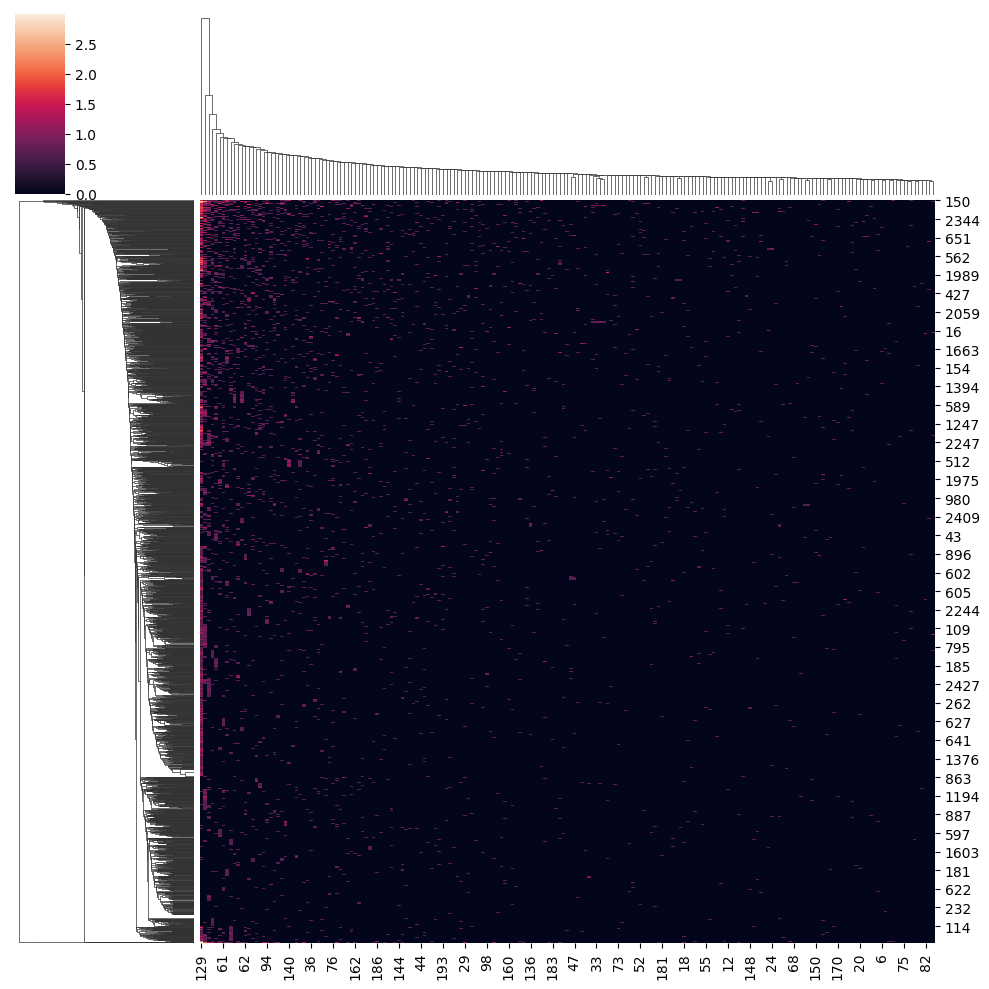

In [11]:
sns.clustermap(np.log1p(hag10_hcc15_hvg200.X.A))

In [12]:
calc_sparsity(np.array(hag10_hcc15_hvg200.X.A,dtype=bool))

0.02594872801154458

In [13]:
cov_hag10_hcc15_hvg200 = empirical_covariance(hag10_hcc15_hvg200.layers["sqrt_counts"].A)

In [14]:
ggl_est = gg_lasso_network_analysis(N=hag10_hcc15_hvg200.shape[0], estimate=cov_hag10_hcc15_hvg200)
ggl_est.create_problem(latent=False)
ggl_est.model_selection(lambda1_range=np.logspace(0, -5, 200))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations wit

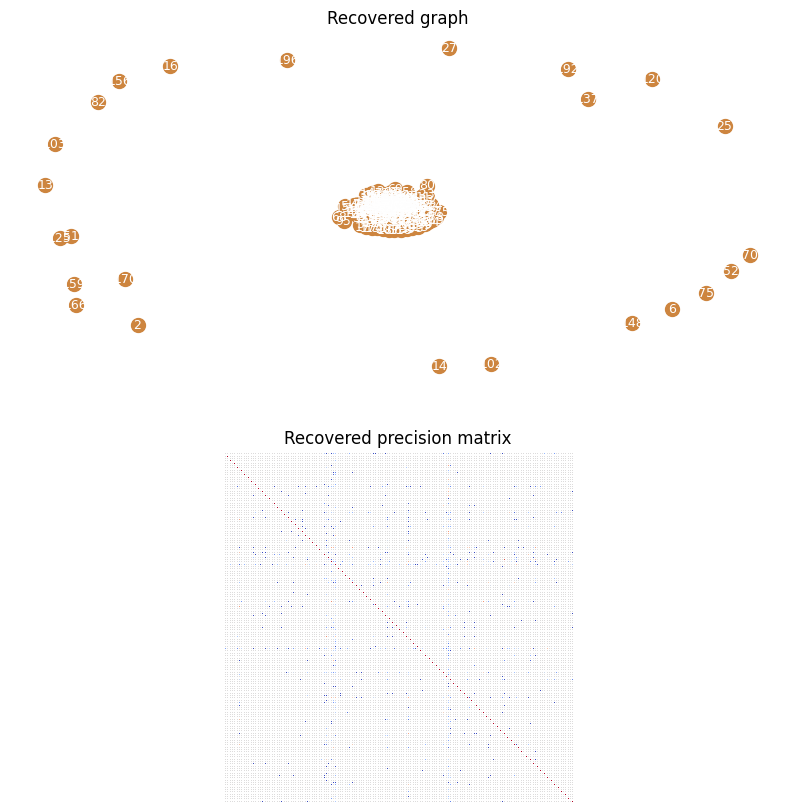

In [15]:
ggl_est.plot_graph_and_percision_matrix(fig_size=(10,10))

In [16]:
sol = ggl_est.P.solution.precision_

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


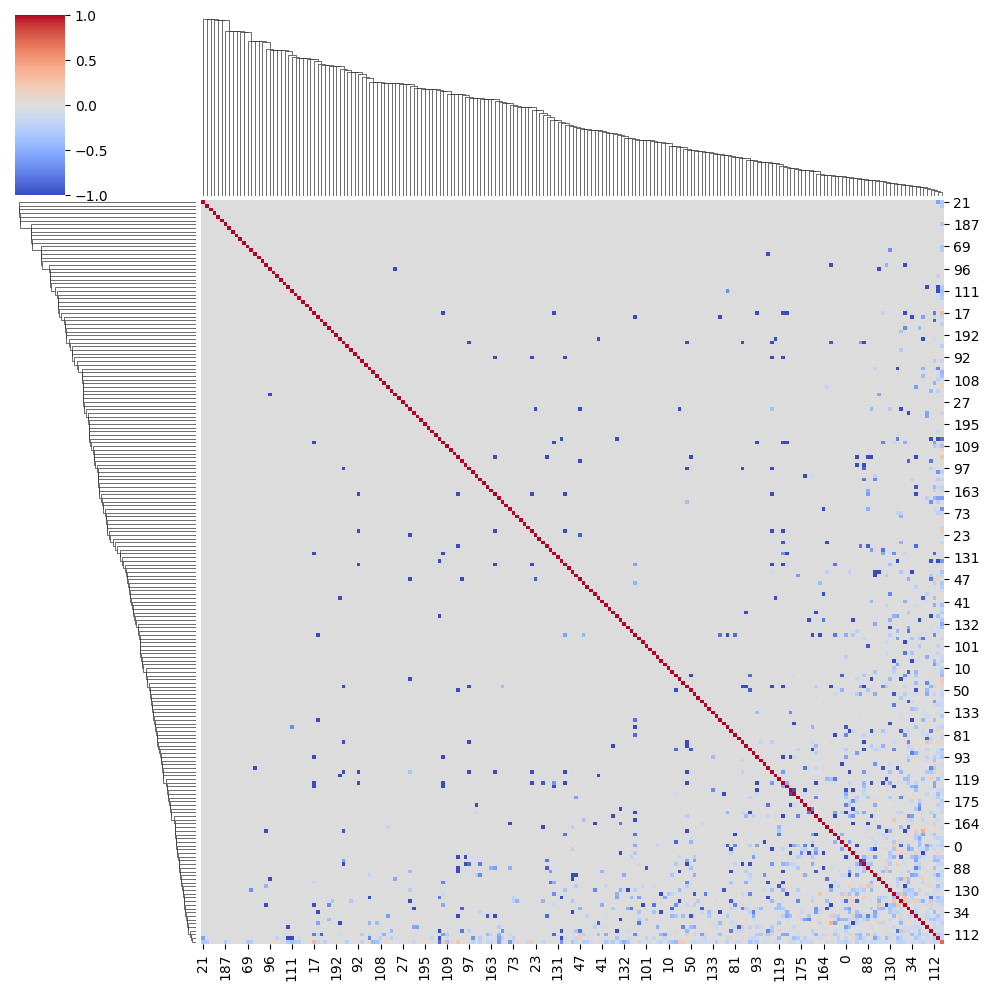

In [17]:
res = sns.clustermap(sol, cmap="coolwarm", vmin=-1, vmax=1)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


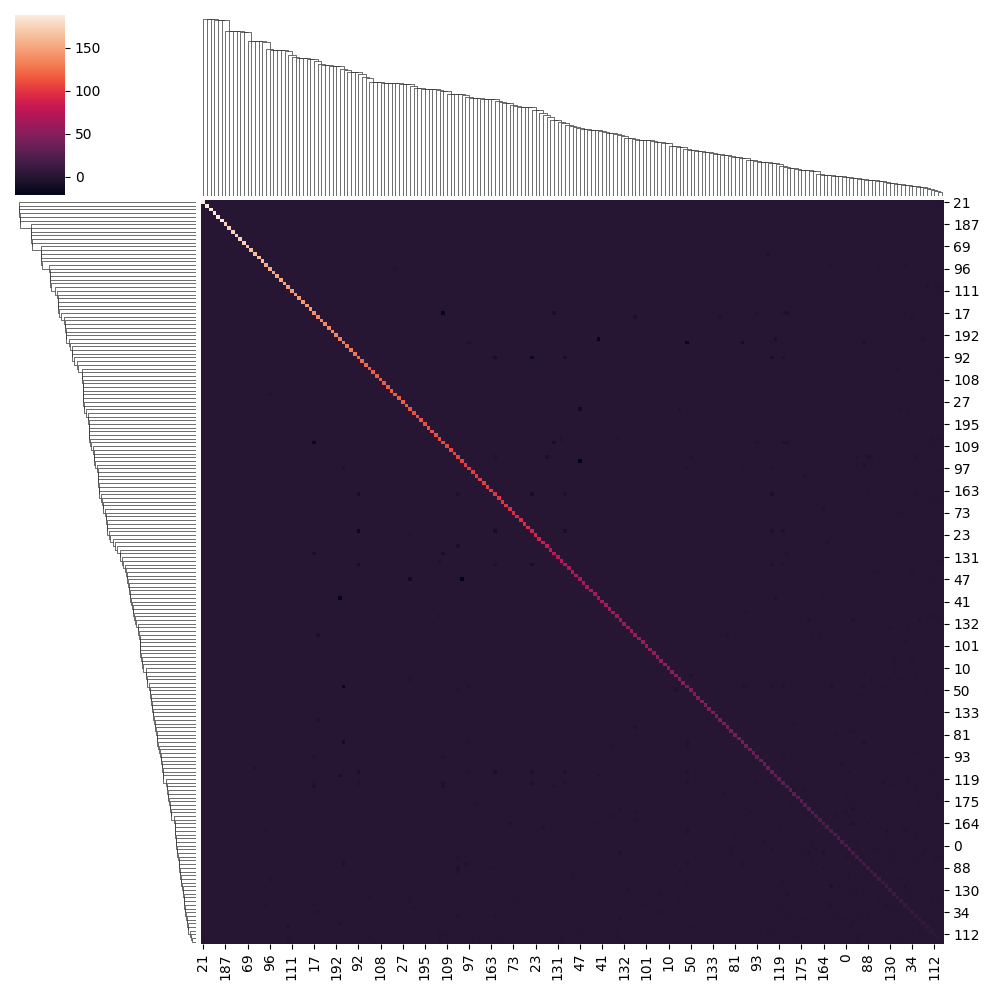

In [18]:
res = sns.clustermap(sol)


In [19]:
ggl_est.P.__dict__

{'S': array([[ 5.75529222e-02,  1.27878878e-03,  5.98883659e-04, ...,
          6.71127799e-04, -4.05107323e-04,  1.44657073e-03],
        [ 1.27878878e-03,  8.16223738e-03,  2.02081036e-03, ...,
          2.65007707e-04, -6.07660985e-05, -9.11491477e-05],
        [ 5.98883659e-04,  2.02081036e-03,  5.32057830e-03, ...,
         -8.91236111e-05, -3.71348379e-05, -5.57022569e-05],
        ...,
        [ 6.71127799e-04,  2.65007707e-04, -8.91236111e-05, ...,
          2.17967995e-02, -1.62042929e-04,  1.67781950e-04],
        [-4.05107323e-04, -6.07660985e-05, -3.71348379e-05, ...,
         -1.62042929e-04,  1.06144870e-02, -1.01276831e-04],
        [ 1.44657073e-03, -9.11491477e-05, -5.57022569e-05, ...,
          1.67781950e-04, -1.01276831e-04,  1.46385531e-02]]),
 'N': 2434,
 'latent': False,
 'G': None,
 'do_scaling': False,
 'conforming': True,
 'multiple': False,
 'p': 201,
 'K': 1,
 'reg_params': {'lambda1': 0.002049074689815846, 'mu1': 0},
 'modelselect_params': {'lambda1_range'

In [20]:
res.dendrogram_row.reordered_ind[:10]

[21, 124, 70, 166, 2, 82, 187, 99, 75, 25]

In [21]:
index_high_corr = hag10_hcc15_hvg200.var.index[res.dendrogram_row.reordered_ind[:10]]
index_high_corr

Index(['cds-WP_002287068.1', 'cds-WP_002294105.1', 'cds-WP_002288850.1',
       'cds-WP_002303062.1', 'cds-WP_002286065.1', 'cds-WP_002289272.1',
       'cds-WP_025478783.1', 'cds-WP_002290055.1', 'cds-WP_002289103.1',
       'cds-WP_002287265.1'],
      dtype='object')

In [22]:
hag10_hcc15_hvg200[:,index_high_corr].var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
cds-WP_002287068.1,GSM5456505_PsA_CDS,match,WP_002287068.1,10,0.004519,99.589154,11.0,10,True,21.0,0.004519,0.005323,1.161227
cds-WP_002294105.1,GSM5456505_PsA_CDS,match,WP_002294105.1,10,0.004519,99.589154,11.0,10,True,20.0,0.004519,0.005323,1.161227
cds-WP_002288850.1,GSM5456505_PsA_CDS,match,WP_002288850.1,10,0.004519,99.589154,11.0,10,True,24.0,0.004519,0.005323,1.161227
cds-WP_002303062.1,GSM5456505_PsA_CDS,match,WP_002303062.1,10,0.004519,99.589154,11.0,10,True,25.0,0.004519,0.005323,1.161227
cds-WP_002286065.1,GSM5456505_PsA_CDS,match,WP_002286065.1,10,0.004519,99.589154,11.0,10,True,23.0,0.004519,0.005323,1.161227
cds-WP_002289272.1,GSM5456505_PsA_CDS,match,WP_002289272.1,10,0.004519,99.589154,11.0,10,True,22.0,0.004519,0.005323,1.161227
cds-WP_025478783.1,GSM5456486_MGH66_Abx3_P1_align2,match,WP_025478783.1,11,0.004930,99.548069,12.0,11,True,39.0,0.004930,0.005730,1.136480
cds-WP_002290055.1,GSM5456505_PsA_CDS,match,WP_002290055.1,11,0.004930,99.548069,12.0,11,True,43.0,0.004930,0.005730,1.136480
cds-WP_002289103.1,GSM5456505_PsA_CDS,match,WP_002289103.1,11,0.004930,99.548069,12.0,11,True,44.0,0.004930,0.005730,1.136480
cds-WP_002287265.1,GSM5456505_PsA_CDS,match,WP_002287265.1,11,0.004930,99.548069,12.0,11,True,40.0,0.004930,0.005730,1.136480


In [23]:
hag10_hcc15_hvg200[:,28].var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
cds-WP_002287304.1,GSM5456505_PsA_CDS,match,WP_002287304.1,21,0.009039,99.137223,22.0,21,True,174.0,0.009039,0.009783,1.040503


In [24]:
hag10_hcc15_hvg200.var.total_counts.value_counts()

total_counts
19.0     12
22.0      8
16.0      8
20.0      8
18.0      7
         ..
57.0      1
138.0     1
150.0     1
71.0      1
51.0      1
Name: count, Length: 89, dtype: int64